<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/2_Seal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net seal detection

In [1]:
#Connect to the google drive if you use Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
!pip install torch torchvision segmentation-models-pytorch tifffile -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torchvision
from PIL import Image
import torch.nn.functional as F

### Define path to tensor files and load train and test data


In [4]:
# Trying the network with the tree data set https://www.kaggle.com/datasets/earthshot/tree-binary-segmentation?resource=download
# DELETE THIS CODE BLOCK ONCE WE HAVE OUR ACTUAL IMAGES

import torchvision.transforms.functional as TF
import random

# Change to relative file paths
train_data_path = "drive/MyDrive/SealNN/Data/Train"
test_data_path = "drive/MyDrive/SealNN/Data/Test"

batch_size = 8  # Can be changed later

def trans(image, mask):
    # Resize and grayscale both mask and image
    resize = transforms.Resize(size=(320, 320))
    grayscale = transforms.Grayscale(num_output_channels=1)

    image = resize(image)
    mask = resize(mask)

    image = grayscale(image)
    mask = grayscale(mask)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # Random rotation
    angle = random.uniform(0, 60)  # Random angle between 0 and 60 degrees
    image = TF.rotate(image, angle)
    mask = TF.rotate(mask, angle)

    # Convert to tensor
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    return image, mask

# Custom dataset to properly import for segmentation
def segmentation_dataset(data_path, transform=None):
    images_path = os.path.join(data_path, "Images")
    masks_path = os.path.join(data_path, "Masks")
    image_files = os.listdir(images_path)

    dataset = []
    for img_name in image_files:
        # Read image and corresponding mask using torchvision.io.read_image
        img_path = os.path.join(images_path, img_name)
        mask_path = os.path.join(masks_path, img_name.replace(".jpg", ".png"))

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if transform:
            mask, image = trans(mask, image)
            #mask = transform(mask)  # Apply transform to both image and corresponding mask

        dataset.append((image, mask))  # Append the image-mask pair to the dataset

    return dataset

# Create train and test datasets without augmentation
train_dataset = segmentation_dataset(train_data_path, transform=trans)
test_dataset = segmentation_dataset(test_data_path, transform=trans)

# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Shuffle on or off?


In [ ]:
# train_data_path = "drive/MyDrive/SealNN/Data/Train" #TODO: change to relative file path
# test_data_path = "drive/MyDrive/SealNN/Data/Test"

# batch_size = 16 #Can be changed later

# #Custom dataset to properly import for segmentation
# def segmentation_dataset(data_path, transform=None):
#   images_path = os.path.join(data_path, "Images")
#   masks_path = os.path.join(data_path, "Masks")
#   image_files = os.listdir(images_path)

#   dataset = []
#   for img_name in image_files:
#         image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
#         mask = tifffile.imread(os.path.join(masks_path, img_name.replace(".tif", "_mask.tif"))) #read corresponding mask .tif file


#         if transform:
#           image = transform(image)
#           mask = transform(mask) #apply transform to both image and corresponding mask

#         dataset.append((image, mask)) #append the image-mask pair in the dataset

#   return dataset

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) #Add more transforms to include e.g. data augmentation

# # Create train and test datasets without augmentation
# train_dataset = segmentation_dataset(train_data_path, transform=transform)
# test_dataset = segmentation_dataset(test_data_path, transform=transform)

# # Create train and test data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Shuffle on or off?

RuntimeError: [Errno 2] No such file or directory: 'drive/MyDrive/SealNN/Data/Train/Masks/0.jpg'

####Visualise image and corresponding mask

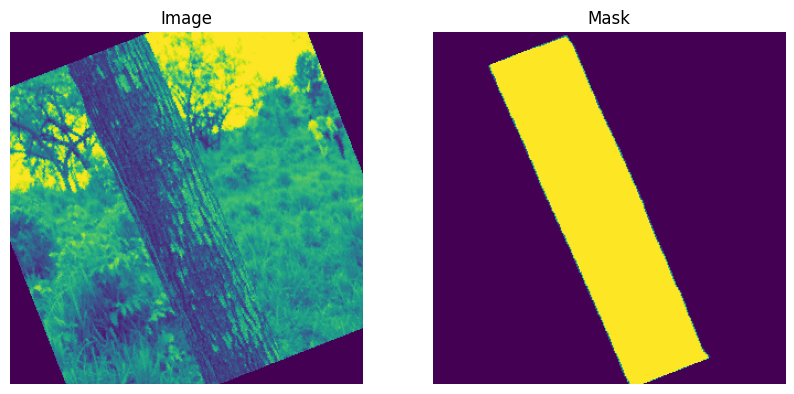

torch.Size([1, 320, 320])
torch.Size([1, 320, 320])


In [5]:
image, mask = train_dataset[15]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

print(image.shape)
print(mask.shape)

###Model generation (U-Net) and training

#### Check GPU

In [6]:
#check the GPU colab assigns to you
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 12 08:06:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

####Define the model (U-Net)

In [7]:
#source:https://smp.readthedocs.io/en/latest/models.html#unet
model = smp.Unet(
    encoder_name="efficientnet-b1", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 we chose efficientnet-b1 based on the SealNet 2.0
    encoder_weights=None, # we do not have a pretrained model, so we put none and the model will use random weigths
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1 # model output channels (number of classes in your dataset)
)

In [ ]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

Epoch 1/20, Train Loss: 0.5548, Test Loss: 0.8000
Epoch 2/20, Train Loss: 0.5542, Test Loss: 0.7976
Epoch 3/20, Train Loss: 0.5381, Test Loss: 0.7677
Epoch 4/20, Train Loss: 0.5352, Test Loss: 0.7942
Epoch 5/20, Train Loss: 0.5333, Test Loss: 0.7490
Epoch 6/20, Train Loss: 0.5236, Test Loss: 0.7308
Epoch 7/20, Train Loss: 0.5200, Test Loss: 0.6934
Epoch 8/20, Train Loss: 0.5329, Test Loss: 0.7085
Epoch 9/20, Train Loss: 0.5164, Test Loss: 0.6752
Epoch 10/20, Train Loss: 0.5179, Test Loss: 0.5498
Epoch 11/20, Train Loss: 0.5121, Test Loss: 0.5491
Epoch 12/20, Train Loss: 0.5169, Test Loss: 0.5798
Epoch 13/20, Train Loss: 0.5075, Test Loss: 0.5894
Epoch 14/20, Train Loss: 0.4948, Test Loss: 0.6122
Epoch 15/20, Train Loss: 0.4937, Test Loss: 0.5303
Epoch 16/20, Train Loss: 0.4881, Test Loss: 0.5863
Epoch 17/20, Train Loss: 0.4872, Test Loss: 0.5157
Epoch 18/20, Train Loss: 0.4850, Test Loss: 0.5053
Epoch 19/20, Train Loss: 0.4713, Test Loss: 0.5584
Epoch 20/20, Train Loss: 0.4731, Test Lo

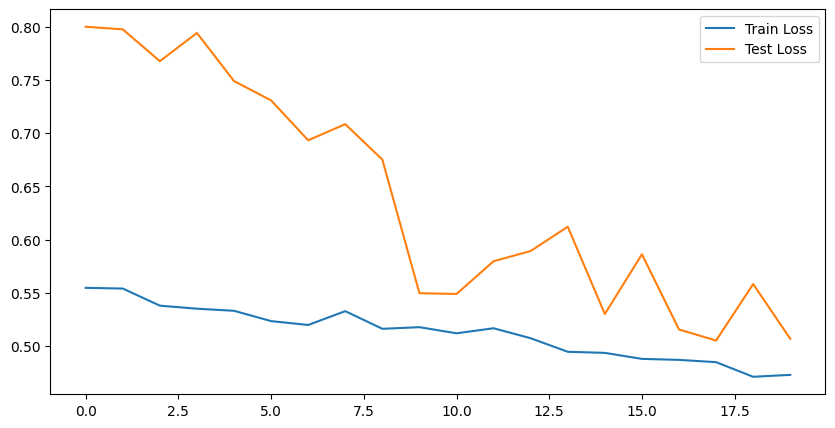

In [92]:
learning_rate = 0.00001
num_epochs = 20

# Define the loss function and optimizer
# Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
ALPHA = 0.5
BETA = 0.8

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky



# What loss function do we want
criterion = TverskyLoss()
#criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss with logits

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for image, mask in train_loader:
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, mask) #mask.float() maybe?
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            outputs = model(image)
            loss = criterion(outputs, mask) #mask.float() maybe?
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

# Prediction visualisation


In [98]:
model.eval()

# Run the model on the test data
all_outputs = []

for image, mask in test_loader:
    image, mask = image.to(device), mask.to(device)
    outputs = model(image)
    outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
    outputs = outputs.cpu().detach()
    all_outputs.append(outputs)

# Concatenate all outputs to match the dataset size
all_outputs = torch.cat(all_outputs, dim=0)

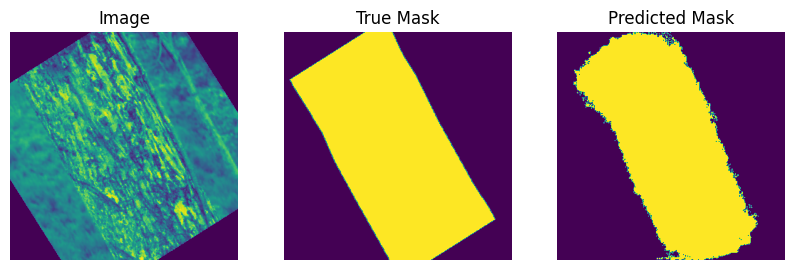

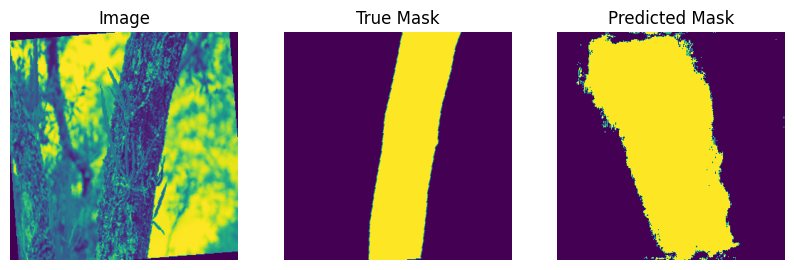

In [116]:
for i in range(len(outputs[:2])):

  # Set visualization variables
  image, mask = test_dataset[i]
  pred = all_outputs[i]
  pred = (pred).round_()
  fig, axes = plt.subplots(1, 3, figsize=(10, 5))

  # Show image on axis 0
  axes[0].imshow(image.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
  axes[0].set_title('Image')
  axes[0].axis('off')

  # Show True mask on axis 1
  axes[1].imshow(mask.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
  axes[1].set_title('True Mask')
  axes[1].axis('off')

  # Show predicted mask on axis 2
  axes[2].imshow(pred.permute(1,2,0))
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

  plt.show()

In [112]:
import torch

# Create a sample tensor
tensor = torch.tensor([[0.2, 0.5], [0.9999, 0.4]])

# Apply the condition
tensor = (tensor > 0.5).float()

print(tensor)

tensor([[0., 0.],
        [1., 0.]])


In [ ]:

  # Plot the histogram
  plt.hist(array[0], edgecolor='black')
  plt.title('Distribution of Tensor Values')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()